In [1]:
## Transformers
from transformers import TFElectraModel, ElectraConfig

## Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, BatchNormalization, GlobalMaxPooling1D, GlobalAveragePooling1D, MaxPooling1D, AveragePooling1D, Concatenate, Flatten

## Utilities
from utils.OneCycleScheduler import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

In [2]:
## Check GPU availability
tf.test.is_built_with_cuda(), tf.config.list_physical_devices('GPU')

(True, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [3]:
f = open('../data/preprocessed.pkl','rb')
train, valid = pickle.load(f)

## Sample subset of train for testing
#train = train.sample(frac = 0.05)
#valid = valid.sample(frac = 0.05)

labels = train.columns[2:]
ys_train = train[labels]
ys_valid = valid[labels]

## COMBINE TOXIC CATEGORIES
y_train = ys_train.sum(axis=1)
y_valid = ys_valid.sum(axis=1)
y_train.loc[y_train>1] = 1
y_valid.loc[y_valid>1] = 1

In [4]:
## Load pretrained Distil Bert Tokenizer
from transformers import ElectraTokenizerFast
electra = 'bert-base-uncased' # pre-trained model
tokenizer = ElectraTokenizerFast.from_pretrained(electra, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

In [5]:
## Tokenizer function
def tokenize(sentences, tokenizer, max_length = 128):
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, 
                                    add_special_tokens=True, 
                                    max_length = max_length, 
                                    pad_to_max_length=True, 
                                    return_attention_mask=True, 
                                    return_token_type_ids=True, 
                                    truncation=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')

In [6]:
## Tokenize all
train_ids, train_masks, train_segs = tokenize(train['comment_text'], tokenizer)
valid_ids, valid_masks, valid_segs = tokenize(valid['comment_text'], tokenizer)

In [7]:
train_ids.shape, train_masks.shape, train_segs.shape

((106912, 128), (106912, 128), (106912, 128))

In [13]:
def build_model(seq_length):
    # Configure transformer model
    config = ElectraConfig()
    config.output_hidden_states = False
    transformer_model = TFElectraModel.from_pretrained(electra, config = config)

    # Inputs
    input_ids = Input(shape=(seq_length,), name='input_token', dtype='int32')
    input_masks_ids = Input(shape=(seq_length,), name='masked_token', dtype='int32')

    # Transformer layer
    X = transformer_model(input_ids, attention_mask=input_masks_ids)[0]

    ## Keras layers
    #X_Max = MaxPooling1D(pool_size=2)(X)
    X = Flatten()(X)
    #X = Dense(300, activation = 'relu')(X)
    #X = Dropout(0.2)(X)
    #X = Dense(100, activation = 'relu')(X)
    #X = Dropout(0.2)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

    # Freeze transformer layers
    for layer in model.layers[:3]:
        layer.trainable = False
    return model

In [14]:
model = build_model(seq_length = train_ids.shape[1])
print(model.summary())

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFElectraModel: ['bert', 'mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['electra']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)              

In [15]:
bs = 5 # batch size

model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['acc'])

lr_finder = LRFinder(max_steps=100) # setup lrfinder. See document for max_lr and min_lr

_ = model.fit(x = [train_ids, train_masks],
              y = y_train,
              batch_size=bs,
              steps_per_epoch=100,
              callbacks=[lr_finder])

100/100 [==============================] - 3s 30ms/step - loss: 91.4626 - acc: 0.8060


(-0.02, 0.0)

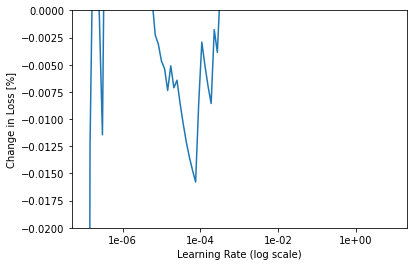

In [16]:
fig, ax = lr_finder.plot_changes()
ax.set_ylim([-0.02,0])
# 1e-5 seems good

In [18]:
## Build model
model = build_model(seq_length = train_ids.shape[1])

## Params
epochs = 100
steps_per_epoch = np.floor(len(train_ids)/bs)

## Define Learning scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        min_delta = 0.0001, 
                                        patience = 10, 
                                        restore_best_weights=True)

## Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='binary_crossentropy',
              metrics='acc')

## Fit model
history = model.fit(x = [train_ids, train_masks],
                    y = y_train,
                    batch_size=bs,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_split = 0.05,
                    callbacks=[lr_scheduler, es]) # add scheduler as callback

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFElectraModel: ['bert', 'mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['electra']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/100
21382/21382 [==============================] - 680s 32ms/step - loss: 0.3573 - acc: 0.8865 - val_loss: 0.3451 - val_acc: 0.9025
Epoch 2

KeyboardInterrupt: 